# ARIMA Model

Brittany Lassiter

**Objectives**

>We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
>
>Make a datetime index using the Date column with a business day frequency ('B').
>
>Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q).
>
>Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days).
>
>Fit an ARIMA model based on the orders determined during your exploration.
>
>Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders).
>
>A MAPE of less than 2% on the test data is achievable.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa

## Functions

In [2]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r_squared = r2_score(y_true, y_pred)
    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
    if output_dict == True:
        metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
        return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)

    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train,results_test])
        # Set the label as the index 
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name=None
        # Return the dataframe
        return results_df.round(3)
    
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])





## Data to Load

In [3]:
# Walmart Stock
df = pd.read_csv('Data/WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


### Make a datetime index using the Date column with a business day frequency ('B')

In [4]:
# cast month as date time, set index, set freq, check nulls
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
# df.resample('B').asfreq()
df = df.asfreq('B')

In [5]:
df.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [6]:
df.dtypes

Adj Close    float64
dtype: object

### We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.

In [7]:
# Filter for 2010-2020 and only the adj close value
df = df.loc['2010':'2020', 'Adj Close']

In [8]:
df.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq='B')

### Check for and address null values.

In [9]:
df.isnull().sum()

101

In [10]:
# Inspect null values
null = df.isna()
df[null].head(20)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
2011-02-21   NaN
2011-04-22   NaN
2011-05-30   NaN
2011-07-04   NaN
2011-09-05   NaN
2011-11-24   NaN
2011-12-26   NaN
2012-01-02   NaN
2012-01-16   NaN
2012-02-20   NaN
Name: Adj Close, dtype: float64

In [11]:
# Fill missing values with previous value
df = df.fillna(method='bfill')

In [12]:
# Testing and Training data 
train, test = train_test_split(df, test_size=.05)

In [13]:
df.shape

(2870,)

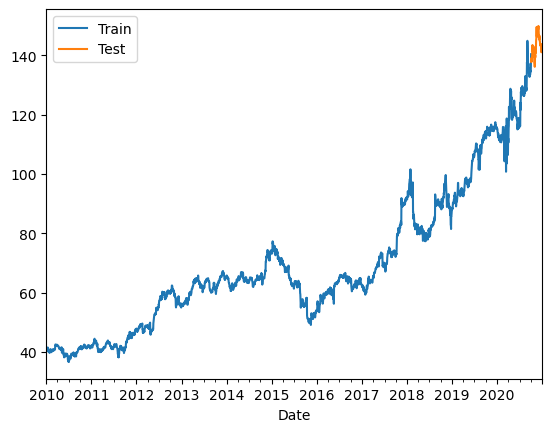

In [14]:
#plt.plot(train)
#plt.plot(test)

# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict quarterly into the future
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

## Checking time series

In [15]:
# Testing the raw data for stationarity
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.467517,23,2846,0.9974,0.05,False


In [16]:
# How many diffs needed?
ndiffs(train)

1

In [17]:
# Dropping the adfuller to check Stationary
df_diff = df.diff().dropna()
get_adfuller_results(df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.193364,22,2846,0.0,0.05,True


**Plot using the diff data with ACF/PACF**

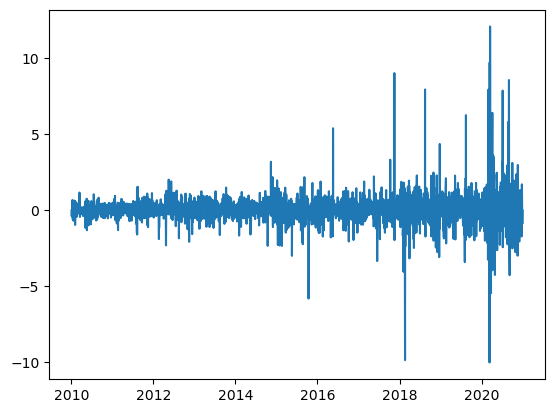

In [18]:
# plot differenced data
plt.plot(df_diff);

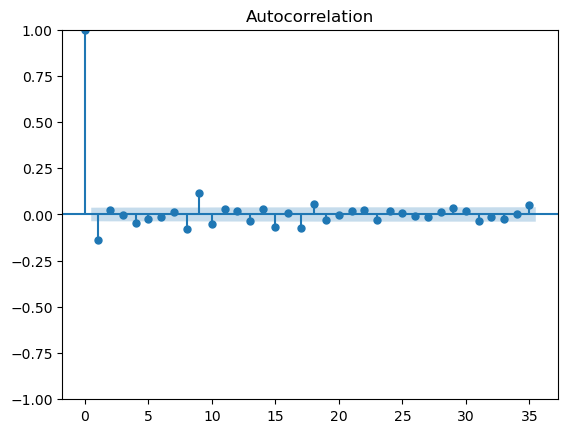

In [19]:
# plot ACF
tsa.graphics.plot_acf(df_diff);

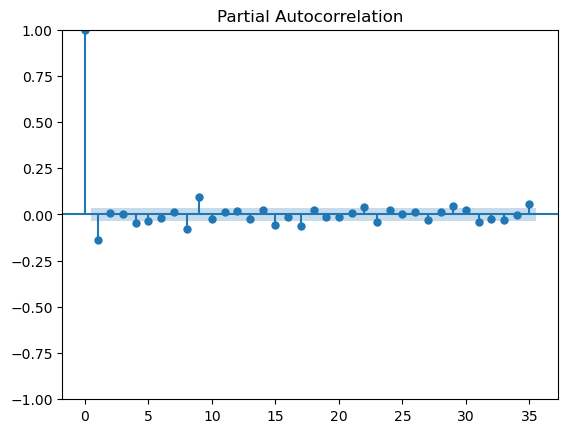

In [20]:
# plot PACF
tsa.graphics.plot_pacf(df_diff, method='ywm');

## Fitting ARIMA

In [21]:
# First define the orders (p,d,q)
p = 2
d = 1
q = 2

# Now instantiate the model with the data and fit
model = tsa.ARIMA(train, order=(p, d, q)).fit()
model

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3883.706
Date:                Tue, 28 Nov 2023   AIC                           7777.412
Time:                        16:06:55   BIC                           7807.106
Sample:                    01-01-2010   HQIC                          7788.130
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7431      0.090      8.290      0.000       0.567       0.919
ar.L2          0.2370      0.046      5.160      0.000       0.147       0.327
ma.L1         -0.8733      0.091     -9.573      0.000      -1.052      -0.694
ma.L2         -0.1101      0.047     -2.350      0.019      -0.202      -0.018
sigma2         0.9345      0.007    143.432      0.000       0.922       0.947
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            110545.63
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              10.43   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Getting forcast 
preds_df = model.get_forecast(steps=len(test)).summary_frame()

**More functions**

In [24]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

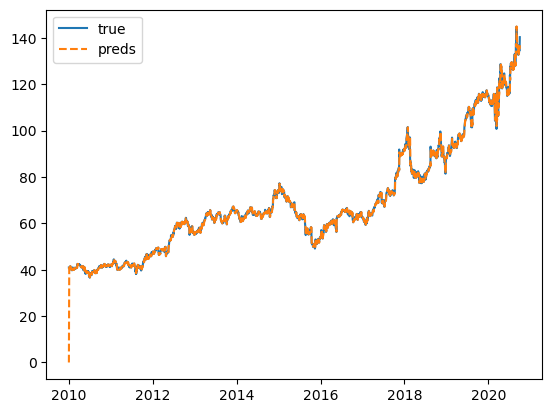

In [26]:
plt.plot(train, label='true')
plt.plot(model.predict(), label='preds', linestyle='--')
plt.legend()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

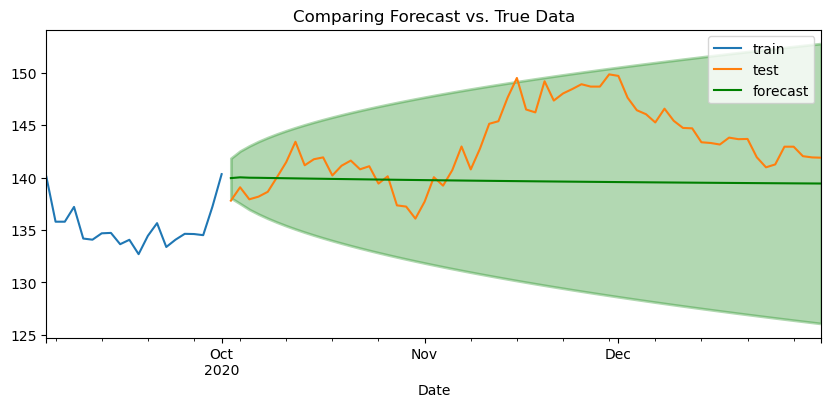

In [27]:
plot_forecast(train.tail(20), test, preds_df)

In [28]:
# use regression_metrics_ts
regression_metrics_ts(test, preds_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.068
- MSE = 25.375
- RMSE = 5.037
- R^2 = -0.987
- MAPE = 2.80%


## Testing more predictions

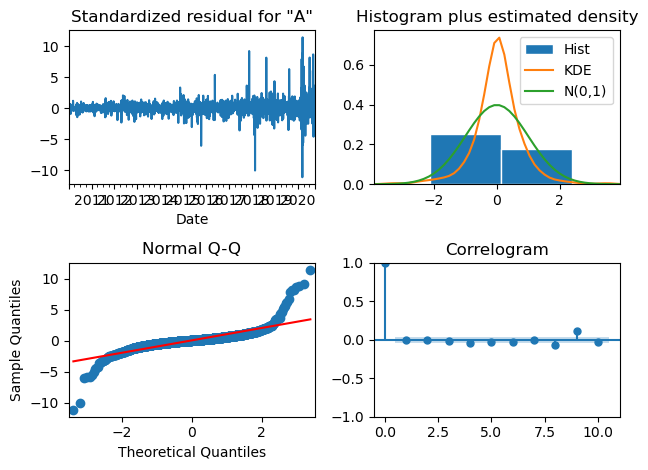

In [29]:
# use model.plot_diagnostics()
model.plot_diagnostics()
plt.tight_layout()

In [31]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [1]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [35]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model_comp = tsa.ARIMA(train, order=pdq)
                              
    result = model_comp.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7819.208494266164
(0, 1, 1) 7774.266617768649
(0, 1, 2) 7773.899773854779
(0, 1, 3) 7774.418547804353
(1, 1, 0) 7772.191998459355
(1, 1, 1) 7773.514649550866
(1, 1, 2) 7775.49879068657
(1, 1, 3) 7770.44801951306
(2, 1, 0) 7773.527030214806
(2, 1, 1) 7775.507116966048
(2, 1, 2) 7777.412123604255
(2, 1, 3) 7763.31541468771
(3, 1, 0) 7775.403360241305
(3, 1, 1) 7771.835905364671


C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2) 7754.912732893003
(3, 1, 3) 7757.481220009246
Best AIC: 7754.912732893003
Best pdq: (3, 1, 2)


In [36]:
# Second defining of the orders (p,d,q)
p = 3
d = 1
q = 2

# Now instantiate the model with the data and fit
model_comp = tsa.ARIMA(train, order=(p, d, q)).fit()
model_comp

C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
model_comp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3871.456
Date:                Tue, 28 Nov 2023   AIC                           7754.913
Time:                        16:12:03   BIC                           7790.546
Sample:                    01-01-2010   HQIC                          7767.774
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6267      0.011    145.936      0.000       1.605       1.649
ar.L2         -0.7461      0.014    -54.796      0.000      -0.773      -0.719
ar.L3         -0.1261      0.007    -17.268      0.000      -0.140      -0.112
ma.L1         -1.7644      0.009   -197.071      0.000      -1.782      -1.747
ma.L2          0.9706      0.009    108.335      0.000       0.953       0.988
sigma2         0.9207      0.008    118.270      0.000       0.905       0.936
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            101377.38
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              10.18   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

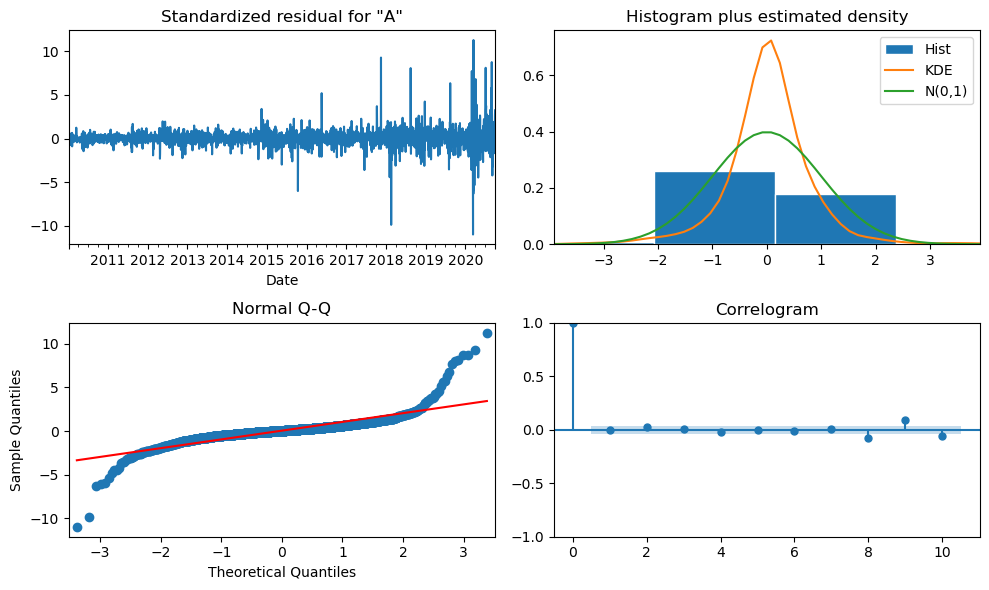

In [39]:
# Obtain diagnostic plots
fig = model_comp.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.831
- MSE = 22.420
- RMSE = 4.735
- R^2 = -0.756
- MAPE = 2.64%


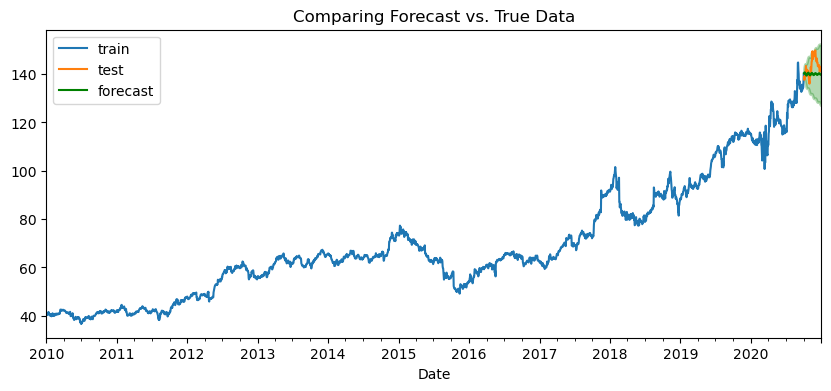

In [40]:
# Obtain summary of forecast as dataframe
forecast_df = model_comp.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

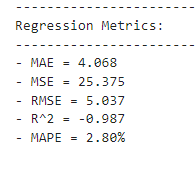
ARIMA 1 (2,1,2)

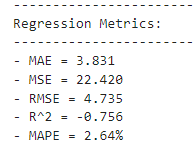
ARIMA 2 (3,1,2)

>*According to my Mean Absolute Percentage Error the second ARIMA performed a little better in each case.*

>*The model seemed to follow the test data well with the forecasting.*